In [1]:
!pip install torchsummary

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchsummary import summary
import warnings
import os
import sys
from tqdm import tqdm
import cv2

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
RESOLUTION = 224

In [5]:
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )

**DATA AUGMENTATION AND VISUALIZING FUNCTIONS**

In [6]:
import os
import cv2
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.transforms import functional as F
from tqdm import tqdm
from typing import Callable, Any

# Define the resolution
RESOLUTION = 224

# Custom data augmentation functions
def random_horizontal_flip(image: Image.Image) -> Image.Image:
    if torch.rand(1) < 0.5:
        image = F.hflip(image)
    return image

def random_rotation(image: Image.Image) -> Image.Image:
    angle = torch.randint(-10, 10, (1,))
    image = F.rotate(image, angle.item())
    return image

# Define the transformation pipeline including multiple data augmentations
transformer = transforms.Compose([
    random_horizontal_flip,
    random_rotation,
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
    transforms.Resize((RESOLUTION, RESOLUTION))
])

In [7]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms

# Define a transform to resize images to 224x224
resize_transform = transforms.Resize((224, 224))

def plot_image_from_list(images, labels, count):
    plt.figure(figsize=(20, 20))  # Increase figure size for larger images
    for i in range(count[0] * count[1]):
        plt.subplot(count[0], count[1], i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img = images[i].to("cpu").numpy()
        if img.shape[0] == 1:  # If the image is single-channel, assume it's grayscale
            img = img.squeeze()
            plt.imshow(img, cmap="gray")
        else:
            plt.imshow(img.transpose((1, 2, 0)))  # Convert from CHW to HWC format
        plt.xlabel(labels[i])
    plt.show()

def plot_randomly_from_dataset(dataset):
    images = []  # List to store selected images
    labels = []  # List to store corresponding labels

    for _ in range(25):
        index = torch.randint(0, len(dataset), (1,)).item()  # Randomly select an index
        image, label = dataset[index]  # Retrieve image and label by index
        image = resize_transform(image)  # Resize image to 224x224
        images.append(image)
        labels.append(dataset.label_id2str(label.item()))

    plot_image_from_list(images, labels, (5, 5))  # Plot the images in a 5x5 grid


**DATA PATHS**

In [9]:
DATA_SOURCE = {
    "Abuse": "/kaggle/input/crimeucfdataset/Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-1/Abuse",
    "Arrest": "/kaggle/input/crimeucfdataset/Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-1/Arrest",
    "Arson": "/kaggle/input/crimeucfdataset/Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-1/Arson",
    "Assault": "/kaggle/input/crimeucfdataset/Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-1/Assault",
    "Burglary": "/kaggle/input/crimeucfdataset/Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-2/Burglary",
    "Explosion": "/kaggle/input/crimeucfdataset/Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-2/Explosion",
    "Fighting": "/kaggle/input/crimeucfdataset/Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-2/Fighting",
    "Normal": "/kaggle/input/crimeucfdataset/Anomaly_Dataset/Anomaly_Videos/Normal-Videos-Part-1"
}

**TRAIN-TEST SPLIT AND VIDEO FRAMES GENERATION WITH DATA AUGMENTATION**

In [10]:
import torch
from torch.utils.data import Dataset
import os
import cv2
from tqdm import tqdm
from PIL import Image

# Assume transformer and DATA_SOURCE are defined somewhere else in the code

class CrimeDataset(Dataset):
    def __init__(self, train=True, train_test_split=0.8, random_state=42):
        torch.manual_seed(random_state)  # Set the random seed for reproducibility
        
        self._data = []  # List to store the image data
        self._labels = []  # List to store the corresponding labels
        self._inclusion_probability = train_test_split if train else 1.0 - train_test_split  # Probability of including a file in the dataset
        self._frame_interval = 30  # Interval to skip frames when reading video
        
        print(f"Loading {'train' if train else 'test' } dataset...")
        for label, data_path in DATA_SOURCE.items():  # Iterate over the data sources
            print(f"Loading Label {label}...")
            for file in tqdm(os.listdir(data_path)):  # Iterate over the files in the data source directory
                if file.endswith(".mp4") and torch.rand(1).item() <= self._inclusion_probability:
                    path = os.path.join(data_path, file)
                    data, labels = self._parse_file(path, label)  # Parse the video file
                    self._data.extend(data)
                    self._labels.extend(labels)
        print(f"Finished loading {'train' if train else 'test' } dataset... Loaded {len(self._data)} images.")
    
    def _parse_file(self, path, label):
        if not os.path.exists(path):
            return [], []
        
        data = []  # List to store frames from the video
        labels = []  # List to store labels corresponding to the frames
        
        cap = cv2.VideoCapture(path)  # Open the video file
        
        success, image = cap.read()
        while success:
            try:
                if True:  # This block processes each frame
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)  # Convert frame to YUV color space
                    Y, U, V = cv2.split(image)  # Split the frame into Y, U, and V components
                    image = transformer(Image.fromarray(Y))  # Apply the transformation to the Y component
                    data.append(image)  # Add the transformed frame to the data list
                    labels.append(label)  # Add the label to the labels list
            except Exception as e:
                print(f"Error loading file {path}: {e}")
            
            count = 0
            while success and count < self._frame_interval:
                success, image = cap.read()  # Read the next frame
                count += 1
        return data, labels
        
    def label_str2id(self, label):
        labels = DATA_SOURCE.keys()
        return list(labels).index(label)  # Convert string label to an ID

    def label_id2str(self, label):
        labels = DATA_SOURCE.keys()
        return list(labels)[label]  # Convert label ID back to a string
        
    def __len__(self):
        return len(self._labels)  # Return the total number of samples in the dataset

    def __getitem__(self, idx):
        data = self._data[idx]  # Get the data (image) at the specified index
        label = self._labels[idx]  # Get the label at the specified index
        return data, torch.tensor([self.label_str2id(label)])  # Return the data and label as a tensor


In [11]:
# Create the training dataset
train_dataset = CrimeDataset(True)  # Initialize with training data

# Create the testing dataset
test_dataset = CrimeDataset(False)  # Initialize with testing data


Loading train dataset...
Loading Label Abuse...


  0%|          | 0/50 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 50/50 [00:52<00:00,  1.04s/it]


Loading Label Arrest...


100%|██████████| 50/50 [01:28<00:00,  1.78s/it]


Loading Label Arson...


100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


Loading Label Assault...


100%|██████████| 50/50 [00:35<00:00,  1.41it/s]


Loading Label Burglary...


100%|██████████| 100/100 [01:50<00:00,  1.10s/it]


Loading Label Explosion...


100%|██████████| 50/50 [00:32<00:00,  1.55it/s]


Loading Label Fighting...


100%|██████████| 50/50 [01:15<00:00,  1.52s/it]


Loading Label Normal...


100%|██████████| 150/150 [03:18<00:00,  1.33s/it]


Finished loading train dataset... Loaded 60416 images.
Loading test dataset...
Loading Label Abuse...


100%|██████████| 50/50 [00:16<00:00,  3.00it/s]


Loading Label Arrest...


100%|██████████| 50/50 [00:34<00:00,  1.47it/s]


Loading Label Arson...


100%|██████████| 50/50 [00:05<00:00,  9.22it/s]


Loading Label Assault...


100%|██████████| 50/50 [00:09<00:00,  5.23it/s]


Loading Label Burglary...


100%|██████████| 100/100 [00:37<00:00,  2.64it/s]


Loading Label Explosion...


100%|██████████| 50/50 [00:14<00:00,  3.38it/s]


Loading Label Fighting...


100%|██████████| 50/50 [00:14<00:00,  3.36it/s]


Loading Label Normal...


100%|██████████| 150/150 [00:41<00:00,  3.65it/s]

Finished loading test dataset... Loaded 17301 images.


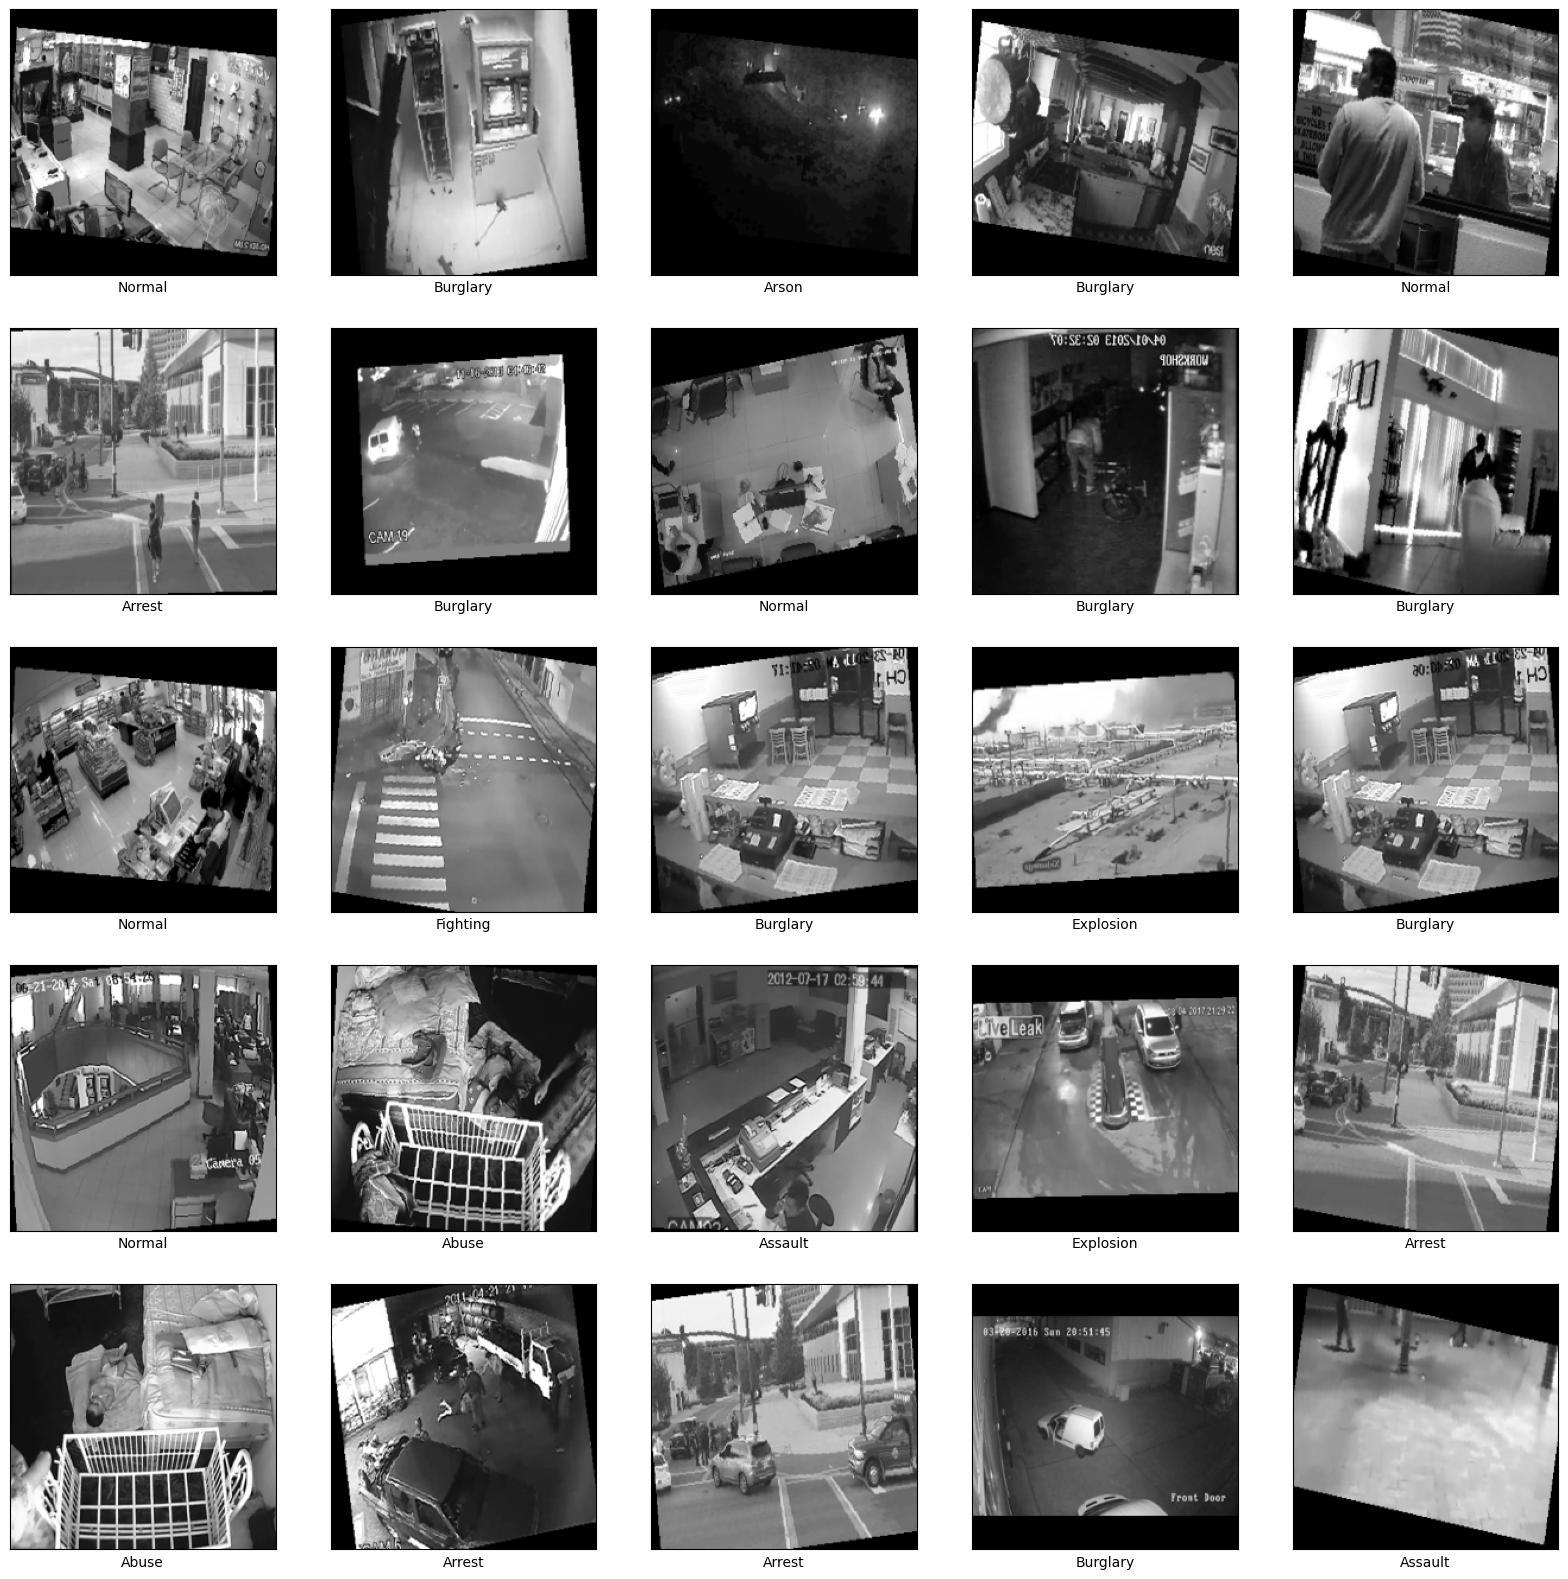

In [12]:
# Load the test dataset randomly
plot_randomly_from_dataset(test_dataset)

In [12]:
# Create a DataLoader for the training dataset
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Create a DataLoader for the testing dataset
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)


In [13]:
# Define number of classes
num_classes = 8

**Convulation Network (Feature Extraction)**

In [14]:
import torch.nn as nn

class CrimeModelCNN(nn.Module):
    def __init__(self):
        super(CrimeModelCNN, self).__init__()
        # First convolutional layer: input channels=1, output channels=64, kernel size=3x3, padding=same
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding="same")
        # Leaky ReLU activation function with a negative slope of 0.1
        self.leaky_relu = nn.LeakyReLU(0.1)
        # Max pooling layer with kernel size=2x2 and stride=2
        self.max_pool1 = nn.MaxPool2d(2, 2)
        # Dropout layer with a probability of 0.25
        self.dropout1 = nn.Dropout(0.25)
        # Second convolutional layer: input channels=64, output channels=128, kernel size=3x3, padding=same
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding="same")
        # Max pooling layer with kernel size=2x2 and stride=2
        self.max_pool2 = nn.MaxPool2d(2, 2)
        # Dropout layer with a probability of 0.25
        self.dropout2 = nn.Dropout(0.25)
        # Third convolutional layer: input channels=128, output channels=256, kernel size=3x3, padding=same
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding="same")
        # Max pooling layer with kernel size=2x2 and stride=2
        self.max_pool3 = nn.MaxPool2d(2, 2)
        # Dropout layer with a probability of 0.4
        self.dropout3 = nn.Dropout(0.4)
        # Flatten layer to convert the 3D tensor to a 1D tensor
        self.flatten = nn.Flatten()
        # Fully connected layer: input size=28*28*256, output size=256
        self.fc1 = nn.Linear(28 * 28 * 256, 256)
        # Dropout layer with a probability of 0.5
        self.dropout4 = nn.Dropout(0.5)

    def forward(self, x):
        # Forward pass through the network
        x = self.conv1(x)
        x = self.leaky_relu(x)
        x = self.max_pool1(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.leaky_relu(x)
        x = self.max_pool2(x)
        x = self.dropout2(x)
        x = self.conv3(x)
        x = self.leaky_relu(x)
        x = self.max_pool3(x)
        x = self.dropout3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.leaky_relu(x)
        x = self.dropout4(x)
        return x


**LSTM Network**

In [15]:

class CrimeModelLSTM(nn.Module):
    def __init__(self):
        super(CrimeModelLSTM, self).__init__()
        # Define the first LSTM layer: input_size=1, hidden_size=8, batch_first=True, bidirectional=False
        self.lstm1 = nn.LSTM(1, 8, batch_first=True, bidirectional=False)
        # Define the second LSTM layer: input_size=8, hidden_size=8, batch_first=True, bidirectional=False
        self.lstm2 = nn.LSTM(8, 8, batch_first=True, bidirectional=False)
        # Define the fully connected layer: input_size=8, output_size=4
        self.fc = nn.Linear(8, 4)
        # Define the dropout layer with a probability of 0.2
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # Forward pass through the network
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]  # Select the last output of the LSTM sequence
        x = self.fc(x)
        x = self.dropout(x)
        return x


**Conv + LSTM Network**

In [16]:
class CrimeModel(nn.Module):
    def __init__(self):
        super(CrimeModel, self).__init__()
        self.cnn = CrimeModelCNN()
        self.lstm = CrimeModelLSTM()
        self.fc = nn.Linear(260, 8)  # Adjust the input size according to your concatenation axis

    def forward(self, x):
        x_cnn = x
        x_lstm = torch.reshape(x, (x.shape[0], RESOLUTION * RESOLUTION, 1))
        x_cnn = self.cnn(x_cnn)
        x_lstm = self.lstm(x_lstm)
        x_combined = torch.cat((x_cnn, x_lstm), dim=1)
        x = self.fc(x_combined)
#         return F.softmax(x, dim=1)
        return x

In [17]:
# Initialize the model
model = CrimeModel()

In [18]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

**MODEL LAYERS**

In [19]:
model = nn.DataParallel(model)
model.to(device)

DataParallel(
  (module): CrimeModel(
    (cnn): CrimeModelCNN(
      (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (leaky_relu): LeakyReLU(negative_slope=0.1)
      (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (dropout1): Dropout(p=0.25, inplace=False)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (dropout2): Dropout(p=0.25, inplace=False)
      (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (max_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (dropout3): Dropout(p=0.4, inplace=False)
      (flatten): Flatten(start_dim=1, end_dim=-1)
      (fc1): Linear(in_features=200704, out_features=256, bias=True)
      (dropout4): Dropout(p=0.5, inplace=False)
    )
    (lstm): CrimeModelLSTM(
      (lstm1): LST

In [20]:
NUM_EPOCHS = 5

In [21]:
for g in optimizer.param_groups:
    g['lr'] = 0.001

**MODEL TRAINING**

Epoch : 1...
Train Loss: 0.1179, Train Accuracy: 0.9642
Test Loss: 1.3668, Test Accuracy: 0.8469, Test AUC-ROC: 0.9535
Epoch : 2...
Train Loss: 0.1017, Train Accuracy: 0.9703
Test Loss: 1.2602, Test Accuracy: 0.8434, Test AUC-ROC: 0.9583
Epoch : 3...
Train Loss: 0.0808, Train Accuracy: 0.97684
Test Loss: 1.3215, Test Accuracy: 0.8423, Test AUC-ROC: 0.9621
Epoch : 4...
Train Loss: 0.0729, Train Accuracy: 0.978944
Test Loss: 1.5609, Test Accuracy: 0.8512, Test AUC-ROC: 0.9643
Epoch : 5...
Train Loss: 0.0821, Train Accuracy: 0.97744
Test Loss: 2.0242, Test Accuracy: 0.8479, Test AUC-ROC: 0.9615


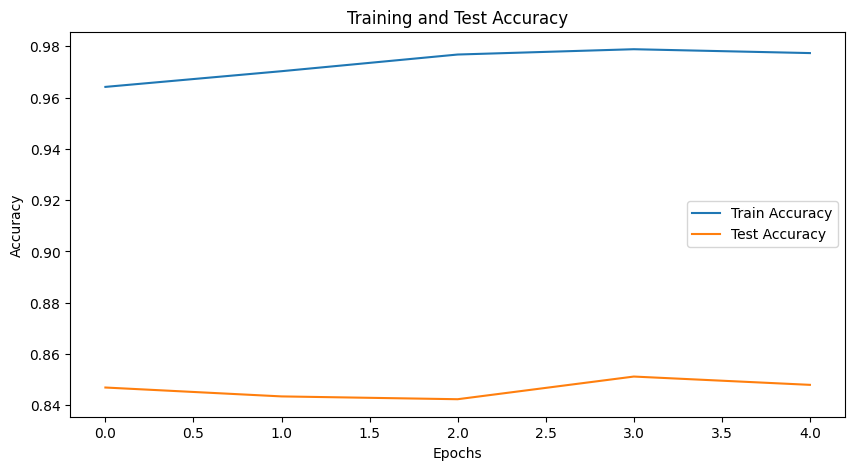

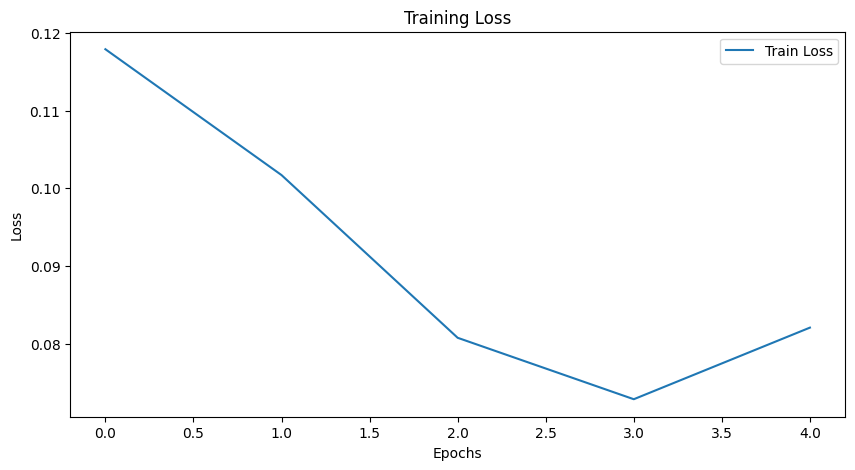

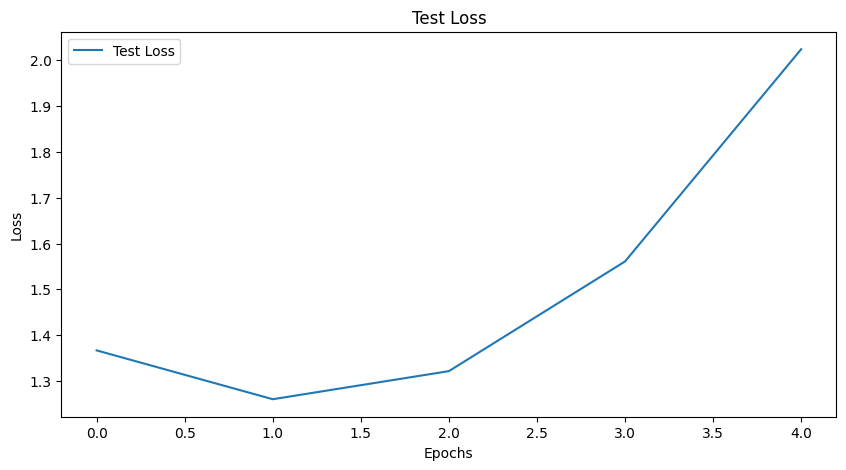

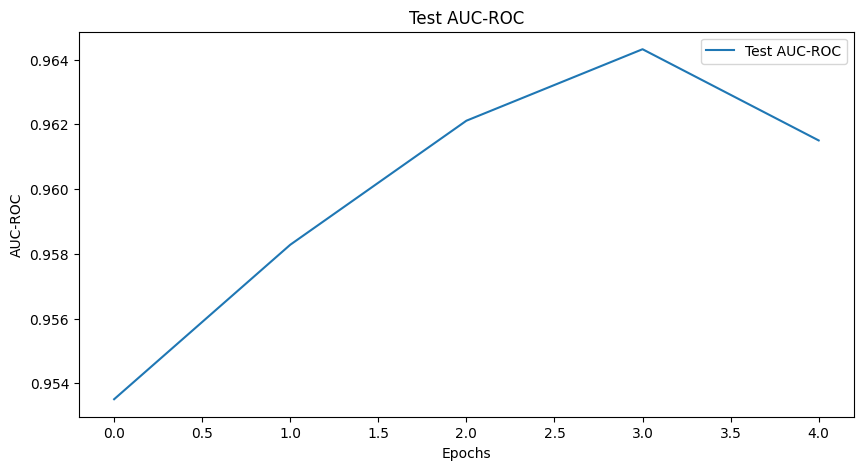

In [24]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

train_loss_history = []
train_accuracy_history = []
test_loss_history = []
test_accuracy_history = []
test_auc_roc_history = []

for epoch in range(NUM_EPOCHS):
    model.train()
    total_correct_train = 0
    total_train_loss = 0

    print(f"Epoch : {epoch + 1}...")

    for batch_idx, (data, label) in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)

        # Ensure label is a 1D tensor of class indices
        label = label.squeeze()

        preds = model(data)
        loss = criterion(preds, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        total_correct_train += (preds.argmax(dim=1) == label).sum().item()

        if batch_idx % 10 == 0:
            print(f"Loss: {loss.item()}, Batch: {batch_idx + 1}/{len(train_loader)}", end="\r")

    # Calculate average loss and accuracy for this epoch
    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = total_correct_train / len(train_loader.dataset)

    train_loss_history.append(avg_train_loss)
    train_accuracy_history.append(train_accuracy)

    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Save the model after each epoch
    torch.save(model.state_dict(), f"crime_model_epoch_{epoch + 1}.pth")

    # Testing
    model.eval()
    total_correct_test = 0
    total_test_loss = 0
    all_test_preds = []
    all_test_labels = []

    with torch.no_grad():
        for data, label in test_loader:
            data = data.to(device)
            label = label.to(device)

            # Ensure label is a 1D tensor of class indices
            label = label.squeeze()

            preds = model(data)
            loss = criterion(preds, label)

            total_test_loss += loss.item()
            total_correct_test += (preds.argmax(dim=1) == label).sum().item()

            # Normalize the predicted probabilities
            preds_normalized = nn.functional.softmax(preds, dim=1)
            all_test_preds.append(preds_normalized)
            all_test_labels.append(label)

    avg_test_loss = total_test_loss / len(test_loader)
    test_accuracy = total_correct_test / len(test_loader.dataset)

    test_loss_history.append(avg_test_loss)
    test_accuracy_history.append(test_accuracy)

    # Calculate and store AUC-ROC
    all_test_preds = torch.cat(all_test_preds, dim=0)
    all_test_labels = torch.cat(all_test_labels, dim=0)
    test_auc_roc = roc_auc_score(all_test_labels.cpu(), all_test_preds.cpu(), multi_class='ovr')
    test_auc_roc_history.append(test_auc_roc)

    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test AUC-ROC: {test_auc_roc:.4f}")

# Plotting the accuracies
plt.figure(figsize=(10, 5))
plt.title("Training and Test Accuracy")
plt.plot(train_accuracy_history, label="Train Accuracy")
plt.plot(test_accuracy_history, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.title("Training Loss")
plt.plot(train_loss_history, label="Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.title("Test Loss")
plt.plot(test_loss_history, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.title("Test AUC-ROC")
plt.plot(test_auc_roc_history, label="Test AUC-ROC")
plt.xlabel("Epochs")
plt.ylabel("AUC-ROC")
plt.legend()
plt.show()

In [45]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

def plot_randomly_from_dataset_model(__dataset, __model):
    images = []  # List to store selected images
    labels = []  # List to store corresponding labels and model predictions

    # Define the transformation to resize images to 224x224 and then convert to tensor
    resize_transform = transforms.Resize((224, 224))
    to_tensor_transform = transforms.ToTensor()

    for _ in range(25):
        index = torch.randint(0, len(__dataset), (1,)).item()  # Randomly select an index
        image, label = __dataset[index]  # Retrieve image and label by index

        # If the image is already a tensor, convert it back to PIL Image first
        if isinstance(image, torch.Tensor):
            image = transforms.ToPILImage()(image)

        # Apply the resize transformation
        image = resize_transform(image)
        image_tensor = to_tensor_transform(image)  # Convert resized image to tensor
        images.append(image_tensor)

        # Get the model prediction for the image
        with torch.no_grad():
            image_tensor = image_tensor.unsqueeze(0).to(device)  # Add batch dimension and move to device
            result = __model(image_tensor).squeeze().cpu().argmax()

        # Append the actual label and predicted label to the labels list
        labels.append(f"{__dataset.label_id2str(label.item())} -> {__dataset.label_id2str(result.item())}")

    plot_image_from_list(images, labels, (5, 5))  # Plot the images in a 5x5 grid

def plot_image_from_list(images, labels, count):
    plt.figure(figsize=(20, 20))  # Increase figure size for larger images
    for i in range(count[0] * count[1]):
        plt.subplot(count[0], count[1], i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img = images[i].to("cpu").numpy()
        if img.shape[0] == 1:  # If the image is single-channel, assume it's grayscale
            img = img.squeeze()
            plt.imshow(img, cmap="gray")
        else:
            plt.imshow(img.transpose((1, 2, 0)))  # Convert from CHW to HWC format
        plt.xlabel(labels[i])
    plt.show()

**MODEL TESTING**

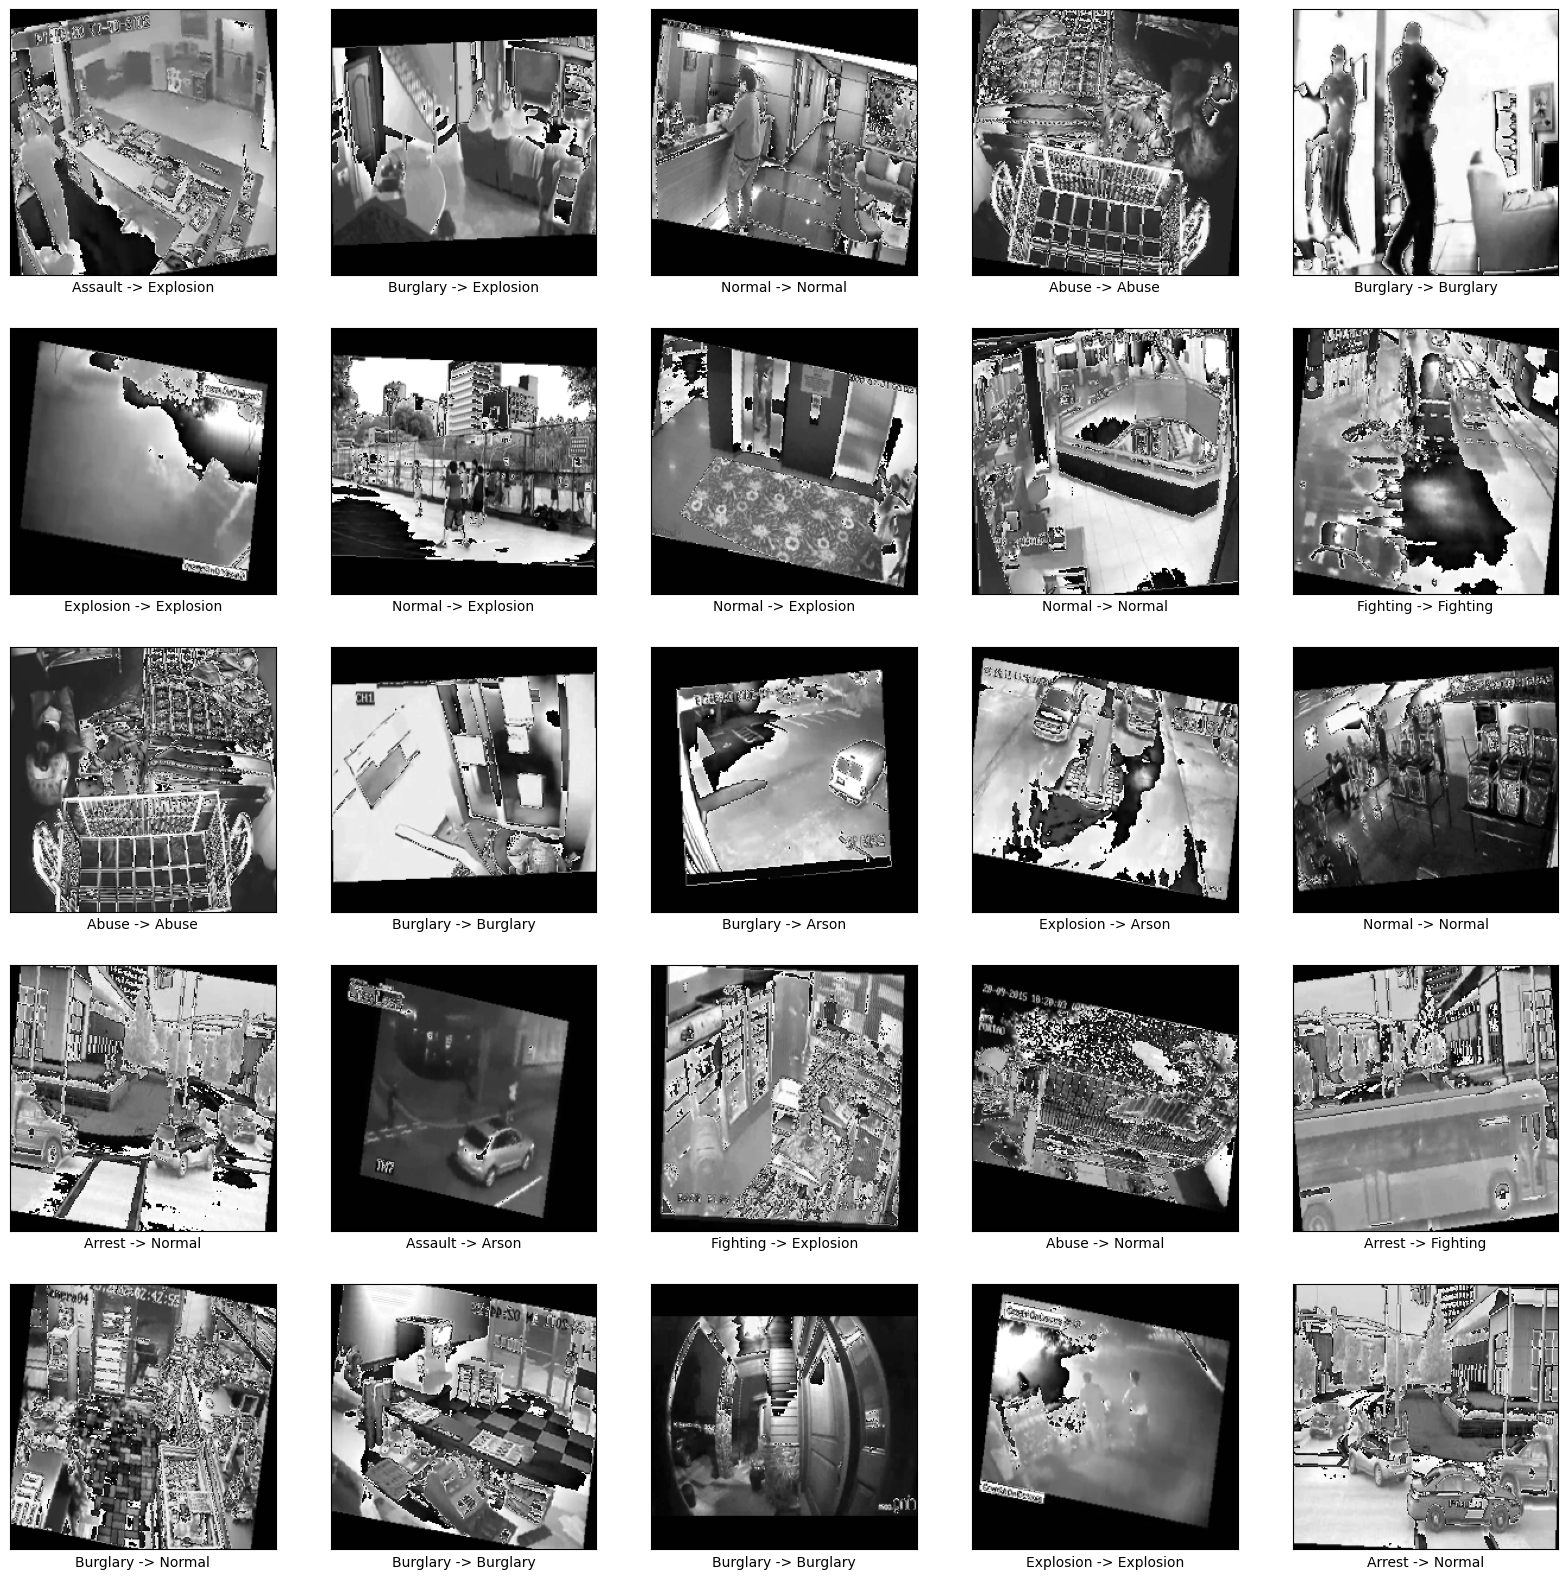

In [48]:
# Test the model
plot_randomly_from_dataset_model(test_dataset, model)